In [1]:
import numpy
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import cProfile
import pstats

In [2]:
plt.interactive(True)

In [3]:

nx = 41
ny = 41
nt = 500
nit = 50
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = numpy.linspace(0, 2, nx)
y = numpy.linspace(0, 2, ny)
X, Y = numpy.meshgrid(x, y)

rho = 1
nu = .1
dt = .001

u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx)) 
b = numpy.zeros((ny, nx))

In [4]:
# The pressure Poisson equation that's written above can be hard to write out without typos. The function build_up_b below represents the contents of the square brackets, so that the entirety of the PPE is slightly more manageable.

def build_up_b(b, rho, dt, u, v, dx, dy):
    
    b[1:-1, 1:-1] = (rho * (1 / dt * 
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / 
                     (2 * dx) + (v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy)) -
                    ((u[1:-1, 2:] - u[1:-1, 0:-2]) / (2 * dx))**2 -
                      2 * ((u[2:, 1:-1] - u[0:-2, 1:-1]) / (2 * dy) *
                           (v[1:-1, 2:] - v[1:-1, 0:-2]) / (2 * dx))-
                          ((v[2:, 1:-1] - v[0:-2, 1:-1]) / (2 * dy))**2))

    return b

In [5]:
# The function pressure_poisson is also defined to help segregate the different rounds of calculations. Note the presence of the pseudo-time variable nit. This sub-iteration in the Poisson calculation helps ensure a divergence-free field.

def pressure_poisson(p, dx, dy, b):
    pn = numpy.empty_like(p)
    pn = p.copy()
    
    for q in range(nit):
        pn = p.copy()
        p[1:-1, 1:-1] = (((pn[1:-1, 2:] + pn[1:-1, 0:-2]) * dy**2 + 
                          (pn[2:, 1:-1] + pn[0:-2, 1:-1]) * dx**2) /
                          (2 * (dx**2 + dy**2)) -
                          dx**2 * dy**2 / (2 * (dx**2 + dy**2)) * 
                          b[1:-1,1:-1])

        p[:, -1] = p[:, -2] # dp/dx = 0 at x = 2
        p[0, :] = p[1, :]   # dp/dy = 0 at y = 0
        p[:, 0] = p[:, 1]   # dp/dx = 0 at x = 0
        p[-1, :] = 0        # p = 0 at y = 2
        
    return p

In [6]:
# Finally, the rest of the cavity flow equations are wrapped inside the function cavity_flow, allowing us to easily plot the results of the cavity flow solver for different lengths of time.

def cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu):
    print('caviry dlow called: nt=',nt)
    un = numpy.empty_like(u)
    vn = numpy.empty_like(v)
    b = numpy.zeros((ny, nx))
    #profiler = cProfile.Profile() # initializing

    
    for n in range(nt):
        un = u.copy()
        vn = v.copy()
        
        
        # profile function build_up_b
        #print('=======profile function build_up_b=====')
        #profiler.enable() # start profiling
        b = build_up_b(b, rho, dt, u, v, dx, dy)
        #profiler.disable() # finish profiling
        #stats = pstats.Stats(profiler).sort_stats('cumtime')
        #stats.print_stats(10)
        
        # profile function pressure_poisson
        #print('======profile pressure_poisson======')
        #profiler.enable() # start profiling
        p = pressure_poisson(p, dx, dy, b)
        #profiler.disable() # finish profiling
        #stats = pstats.Stats(profiler).sort_stats('cumtime')
        #stats.print_stats(10)
        
        u[1:-1, 1:-1] = (un[1:-1, 1:-1]-
                         un[1:-1, 1:-1] * dt / dx *
                        (un[1:-1, 1:-1] - un[1:-1, 0:-2]) -
                         vn[1:-1, 1:-1] * dt / dy *
                        (un[1:-1, 1:-1] - un[0:-2, 1:-1]) -
                         dt / (2 * rho * dx) * (p[1:-1, 2:] - p[1:-1, 0:-2]) +
                         nu * (dt / dx**2 *
                        (un[1:-1, 2:] - 2 * un[1:-1, 1:-1] + un[1:-1, 0:-2]) +
                         dt / dy**2 *
                        (un[2:, 1:-1] - 2 * un[1:-1, 1:-1] + un[0:-2, 1:-1])))

        v[1:-1,1:-1] = (vn[1:-1, 1:-1] -
                        un[1:-1, 1:-1] * dt / dx *
                       (vn[1:-1, 1:-1] - vn[1:-1, 0:-2]) -
                        vn[1:-1, 1:-1] * dt / dy *
                       (vn[1:-1, 1:-1] - vn[0:-2, 1:-1]) -
                        dt / (2 * rho * dy) * (p[2:, 1:-1] - p[0:-2, 1:-1]) +
                        nu * (dt / dx**2 *
                       (vn[1:-1, 2:] - 2 * vn[1:-1, 1:-1] + vn[1:-1, 0:-2]) +
                        dt / dy**2 *
                       (vn[2:, 1:-1] - 2 * vn[1:-1, 1:-1] + vn[0:-2, 1:-1])))

        u[0, :]  = 0
        u[:, 0]  = 0
        u[:, -1] = 0
        u[-1, :] = 1    # set velocity on cavity lid equal to 1
        v[0, :]  = 0
        v[-1, :] = 0
        v[:, 0]  = 0
        v[:, -1] = 0
        
        
    return u, v, p

caviry dlow called: nt= 5000
         290088 function calls in 5.666 seconds

   Ordered by: cumulative time
   List reduced from 43 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    5.666    2.833 /chalmers/users/panmor/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3397(run_code)
        2    0.000    0.000    5.666    2.833 {built-in method builtins.exec}
        1    0.000    0.000    5.666    5.666 /tmp/ipykernel_5967/3096820521.py:12(<module>)
        1    0.510    0.510    5.666    5.666 /tmp/ipykernel_5967/1600096264.py:3(cavity_flow)
     5000    4.764    0.001    4.942    0.001 /tmp/ipykernel_5967/1014804508.py:3(pressure_poisson)
     5000    0.207    0.000    0.207    0.000 /tmp/ipykernel_5967/2297992397.py:3(build_up_b)
   265000    0.177    0.000    0.177    0.000 {method 'copy' of 'numpy.ndarray' objects}
     5002    0.003    0.000    0.007    0.000 <__array_function

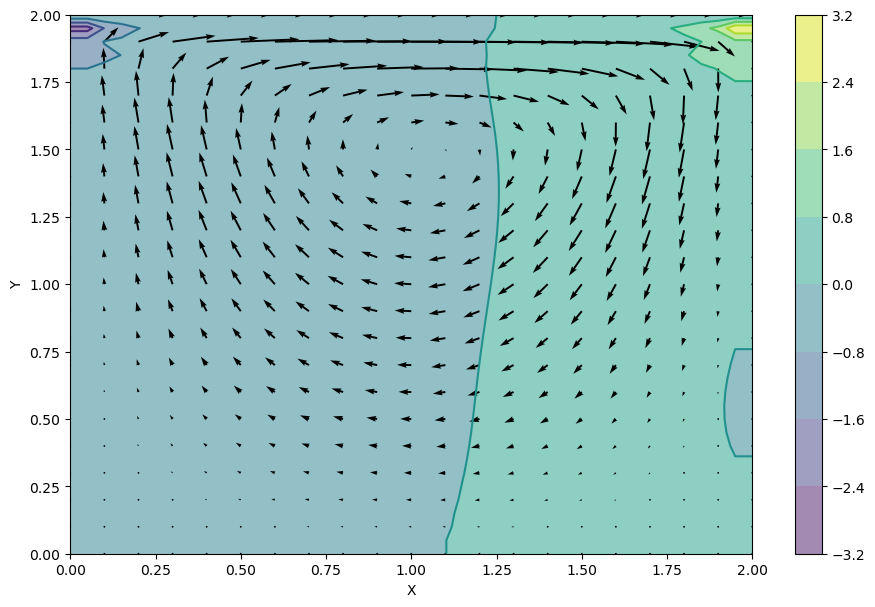

In [7]:
# Let's start with nt = 100 and see what the solver gives us:

u = numpy.zeros((ny, nx))
v = numpy.zeros((ny, nx))
p = numpy.zeros((ny, nx))
b = numpy.zeros((ny, nx))
nt = 5000

profiler = cProfile.Profile() # initializing

profiler.enable() # start profiling
u, v, p = cavity_flow(nt, u, v, dt, dx, dy, p, rho, nu)
profiler.disable() # finish profiling

stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats(10)


fig = pyplot.figure(figsize=(11,7), dpi=100)
# plotting the pressure field as a contour
pyplot.contourf(X, Y, p, alpha=0.5, cmap=cm.viridis)  
pyplot.colorbar()
# plotting the pressure field outlines
pyplot.contour(X, Y, p, cmap=cm.viridis)  
# plotting velocity field
pyplot.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
pyplot.xlabel('X')
pyplot.ylabel('Y');